# Importing Libraries

In [1]:
import os
from osgeo import gdal
from netCDF4 import Dataset, num2date
import numpy as np
import numpy.ma as ma
import xarray as xr
from mpl_toolkits.basemap import Basemap, interp
from scipy import interpolate
from scipy.interpolate import interp2d
import pyinterp
import pyinterp.backends.xarray as pbx
import xesmf as xe
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cdo as cdo
cdo = cdo.Cdo()


Bad key "text.kerning_factor" on line 4 in
/home/splash/anaconda3/envs/om/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Basemap (Data loaded using xArray)

In [6]:
ds = xr.open_dataset('/home/splash/data/metoc_output/ncep/mww3/mww3_20200607.nc').isel(time=0)
lon = ds['lon'].values
lat = ds['lat'].values
WVDIR = ds['wdir'].values

#Defining new grid spacing
lons_sub, lats_sub = np.meshgrid(np.arange(-180, 180, 0.066),
                     np.arange(-90, 90, 0.066))

In [7]:
#Applying interpolation function
bmbil = interp(datain=WVDIR, xin=lon, yin=lat, xout=lons_sub, yout=lats_sub, order=1)

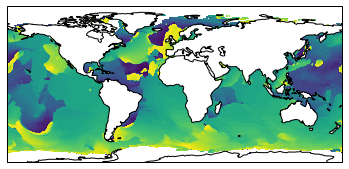

In [4]:
#Plot to check results
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons_sub, lats_sub, bmbil, 60,
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

# Basemap (Data loaded using NetCDF4)

In [3]:
filename = '/home/splash/data/metoc_output/ncep/mww3/mww3_20200607.nc'
with Dataset(filename, mode='r') as fh:
    lon = fh.variables['lon'][:]
    lat = fh.variables['lat'][:]
    WVDIR = fh.variables['wdir'][0,:,:]
lons_sub, lats_sub = np.meshgrid(np.arange(-180, 180, 0.066),
                     np.arange(-90, 90, 0.066))

In [4]:
#Applying interpolation function
bmbilN = interp(datain=WVDIR, xin=lon, yin=lat, xout=lons_sub, yout=lats_sub, order=1)

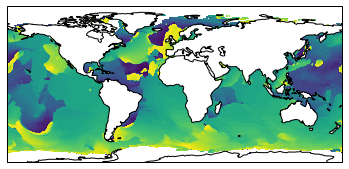

In [5]:
#Plot to check results
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons_sub, lats_sub, bmbilN, 60,
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

# xArray

In [2]:
ds = xr.open_dataset('/home/splash/data/metoc_output/ncep/mww3/mww3_20200607.nc').isel(time=0)

#Selecting variable
dsV = ds['wdir']

#Renaming grid variables, because xArray accepts them as lat & lon
#dsR = dsV.rename({'latitude': 'lat','longitude': 'lon'})

#Defining new grid spacing
x = np.arange(-90, 90, 0.066)
y = np.arange(-180, 180, 0.066)

In [3]:
#Applying interpolation function
xrbil = dsV.interp(lat=x, lon=y)

In [ ]:
#Export to netcdf
#xrbil.to_netcdf('FILENAME.nc')

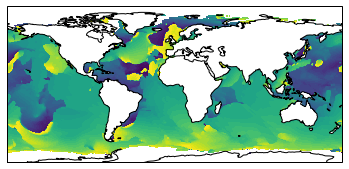

In [4]:
#Plot to check results
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(y, x, xrbil, 60,
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

# Correlation

In [8]:
#Masking nan values from both arrays
a=ma.masked_invalid(bmbil)
b=ma.masked_invalid(xrbil)

#logical AND of non-nan masks
msk = (~a.mask & ~b.mask)

print(ma.corrcoef(a[msk],b[msk]))

[[1.0 0.9999999999999999]
 [0.9999999999999999 1.0]]


# Printing size of any array if required 

In [ ]:
print("%d bytes" % (bmbil.size * bmbil.itemsize))

# SciPy - DISCARDED because of inconsistent results

In [ ]:
ds = xr.open_dataset('/home/splash/data/metoc_output/ncep/mww3/mww3_20200607.nc').isel(time=0)
lon = ds['lon'].values
lat = ds['lat'].values
WVDIR = ds['wdir'].values

lat_new = np.arange(-90, 90, 0.066)
lon_new = np.arange(-180, 180, 0.066)

func = interpolate.interp2d(lon, lat, WVDIR, kind='linear')
scipyinterp = func(lon_new, lat_new)

In [ ]:
#Plot to check results
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon_new, lat_new, scipyinterp, 60,
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

# PyInterp - DISCARDED because of inconsistent results

In [ ]:
ds = xr.open_dataset('/home/splash/data/metoc_output/ncep/mww3/mww3_20200607.nc').isel(time=0)
#ds = d.rename({'latitude': 'lat','longitude': 'lon'})
interpolator = pbx.Grid2D(ds.data_vars["wdir"])
mx, my = np.meshgrid(np.arange(-180, 180, 0.066),
                     np.arange(-90, 90, 0.066),
                     indexing='ij')
pyinbil = interpolator.bivariate(dict(lon=mx.flatten(), lat=my.flatten())).reshape(mx.shape)

# xESMF - DISCARDED because of installation issues

In [ ]:
ds = xr.open_dataset('/home/splash/data/metoc_output/ncep/mww3/mww3_20200607.nc').isel(time=0)
WVDIR = ds['wdir']

ds['lat'].values, ds['lon'].values

ds_out = xr.Dataset({'lat': (['lat'], np.arange(ds['lat'][0], ds['lat'][-1], 0.066)),
                     'lon': (['lon'], np.arange(ds['lon'][0], ds['lon'][-1], 0.066)),
                    }
                   )
regridder = xe.Regridder(ds, ds_out, 'bilinear', reuse_weights=True)
dr_out = regridder(dr)
#dr_out.to_netcdf('rtofs_uo_0_066_xesmf_bilinear.nc')

Create weight file: bilinear_336x720_2538x5447.nc


# CDO

In [ ]:
#Grid definition
grid="/home/splash/mygrid.txt"
ifile = xr.open_dataset('/home/splash/data/metoc_output/ncep/mww3/mww3_20200607.nc').isel(time=0)
ofile="/home/splash/mww3Bil.nc"
#Generating weights
cdo.genbil(grid, input = ifile, output = "weightsBil.nc", options = '-f nc')
#Applying weights
cdo.remap(grid, 'weightsBil.nc', input = ifile, output = ofile, options = '-f nc')